In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import networkx as nx
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# import helper functions from the functions.py file
import functions as f

TTN_BIN = 4277
TTN_BINS = [4275, 4276, 4277, 4278]
chrom2_bins = [2490, 4911]

In [462]:
contact_matrix = np.load('/Users/ethan/Desktop/chromatin-heart-dev/samples/contact_matrix_100kb_balanced.npy')

In [463]:
# LOAD BIN MAP
bin_map = f.load_bin_map('/Users/ethan/Desktop/chromatin-heart-dev/data/bin_map_human_100000.bed')

## Finding TTN Clique Greedy

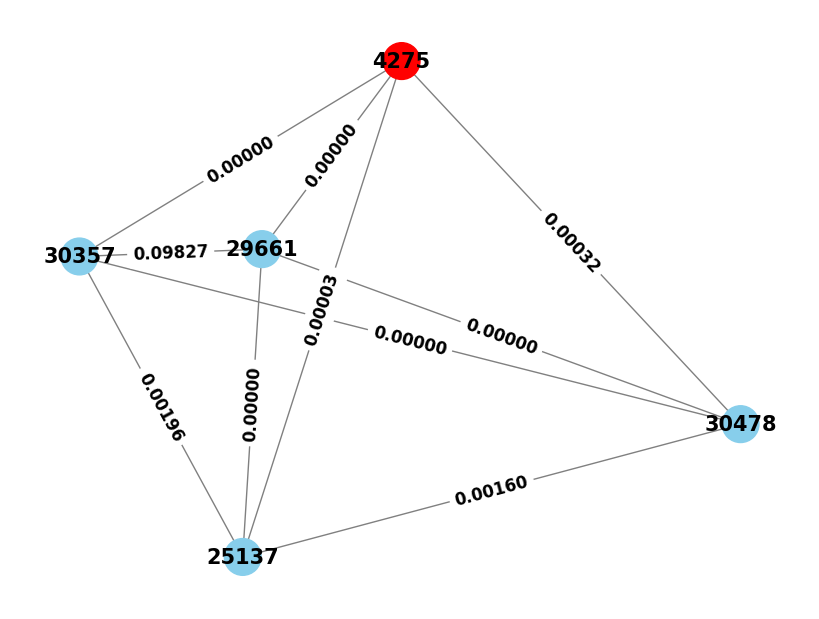

In [464]:
TTN_BIN = 4275
ttn_clique = f.find_clique_greedy(contact_matrix, 5, TTN_BIN, bin_map)
G_TTN = f.clique_to_graph(contact_matrix, ttn_clique, TTN_BIN)
score_greedy = f.calculate_avg_interaction_strength(contact_matrix, ttn_clique)

In [465]:
ttn_clique, score_greedy

([4275, 30478, 25137, 30357, 29661], np.float64(0.010217975885194035))

## Background Model Generation

Processing: 100%|██████████| 1000/1000 [04:05<00:00,  4.08iteration/s]


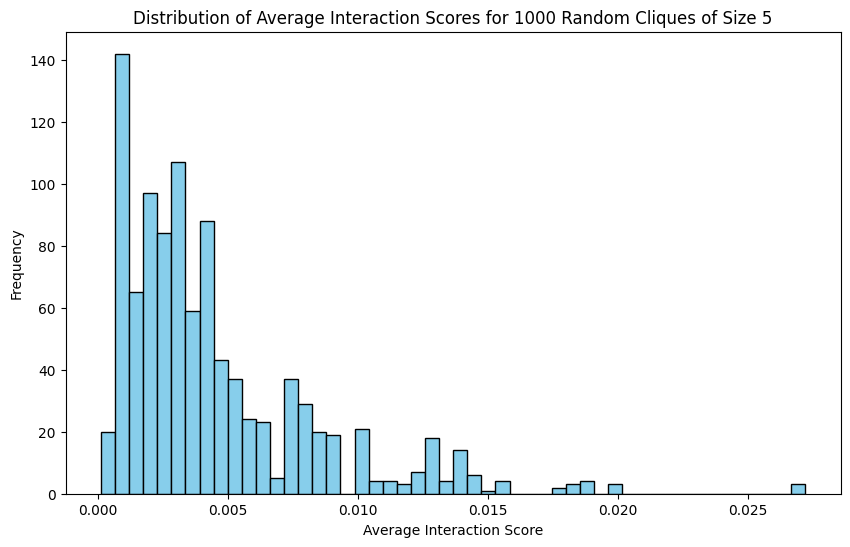

In [486]:
bg_greedy_5 = f.create_background_model_greedy(contact_matrix, 5, bin_map, 1000)

In [ ]:
f.simple_p_test(score_greedy, bg_greedy_5)

np.float64(0.087)

Processing: 100%|██████████| 100/100 [00:58<00:00,  1.71iteration/s]


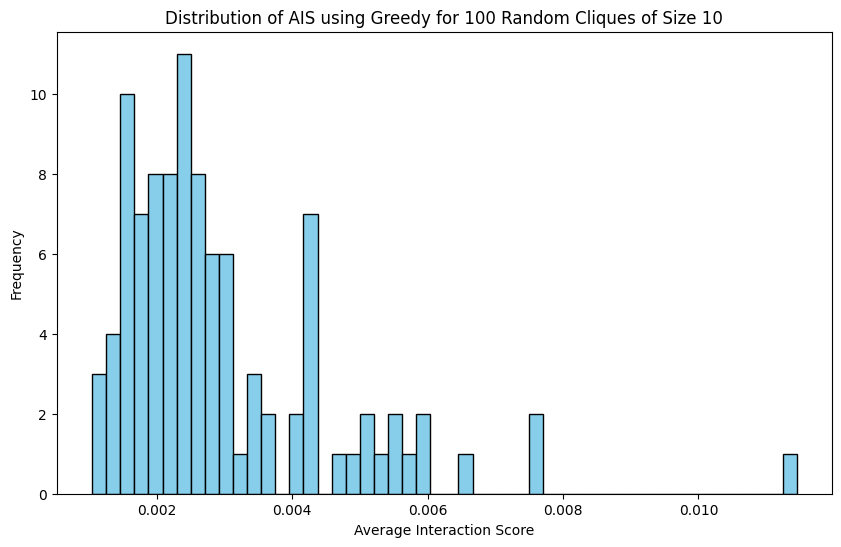

In [501]:
bg_greedy_10 = f.create_background_model_greedy(contact_matrix, 10, bin_map, 100)

In [504]:
greedy_score_10 = f.calculate_avg_interaction_strength(contact_matrix, f.find_clique_greedy(contact_matrix, 10, TTN_BIN, bin_map))
print(greedy_score_10)
print(f.simple_p_test(greedy_score_10, bg_greedy_10))

0.003796834802173981
0.23


Processing: 100%|██████████| 100/100 [02:13<00:00,  1.34s/iteration]


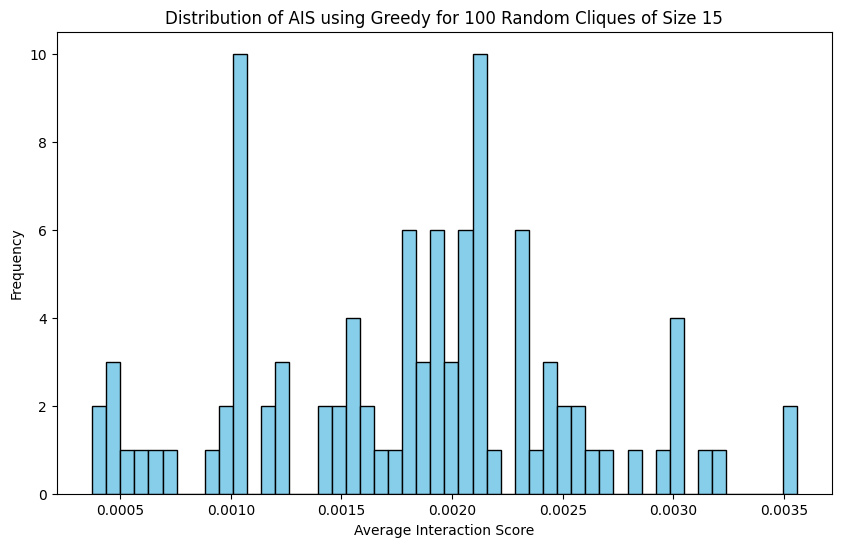

In [506]:
bg_greedy_15 = f.create_background_model_greedy(contact_matrix, 15, bin_map, 100)

In [509]:
greedy_score_15 = f.calculate_avg_interaction_strength(contact_matrix, f.find_clique_greedy(contact_matrix, 15, TTN_BIN, bin_map))
print(greedy_score_15)
print(f.simple_p_test(greedy_score_15, bg_greedy_15))

0.0023150855197524175
0.22


# Diffusion

## Setup

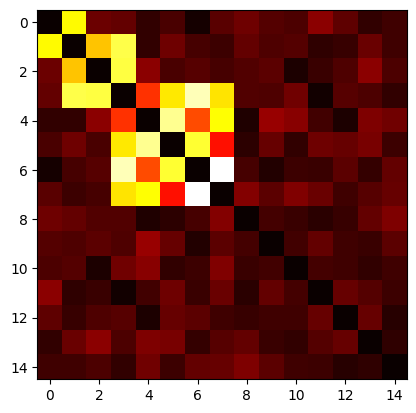

In [3]:
# create a sample matrix
contact_matrix = f.generate_sample_matrix_bins(15)

# visualize the contact matrix hic 
plt.imshow(contact_matrix, cmap='hot', interpolation='nearest')
plt.show()


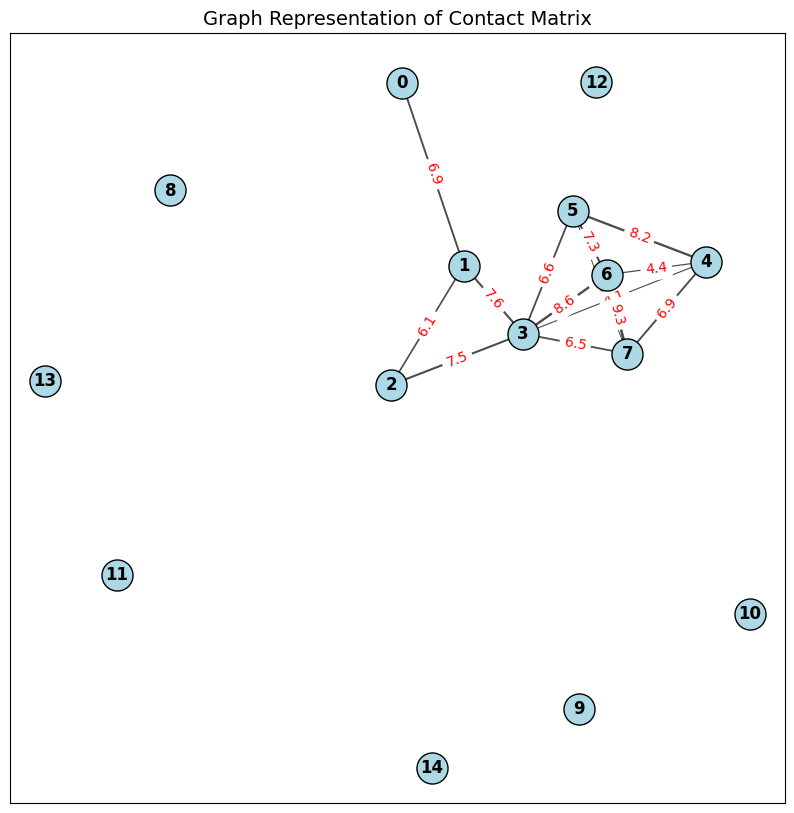

In [ ]:


# zero out cm if not above 2
contact_matrix = np.where(contact_matrix < 2, 0, contact_matrix)

# plot this on a graph
G = f.construct_graph_from_contact_matrix(contact_matrix, threshold=0)



In [290]:
contact_matrix[2]

array([0.        , 6.0969454 , 0.        , 7.48686075, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ])

In [4]:
contact_matrix_zero = np.load('/Users/ethan/Desktop/chromatin-heart-dev/samples/contact_matrix_100kb_balanced_zeroed.npy')

## Random Walk Clique Size 5

In [399]:
top_nodes = f.random_walk(contact_matrix_zero, TTN_BIN, 5, num_molecules=1000, alpha=0.05, verbose=True) 
rw_score_5  = f.calculate_avg_interaction_strength(contact_matrix_zero, top_nodes)
rw_score_5  


100%|██████████| 1000/1000 [00:03<00:00, 290.04it/s]


np.float64(0.0003882285340160518)

Processing: 100%|██████████| 100/100 [04:52<00:00,  2.92s/iteration]


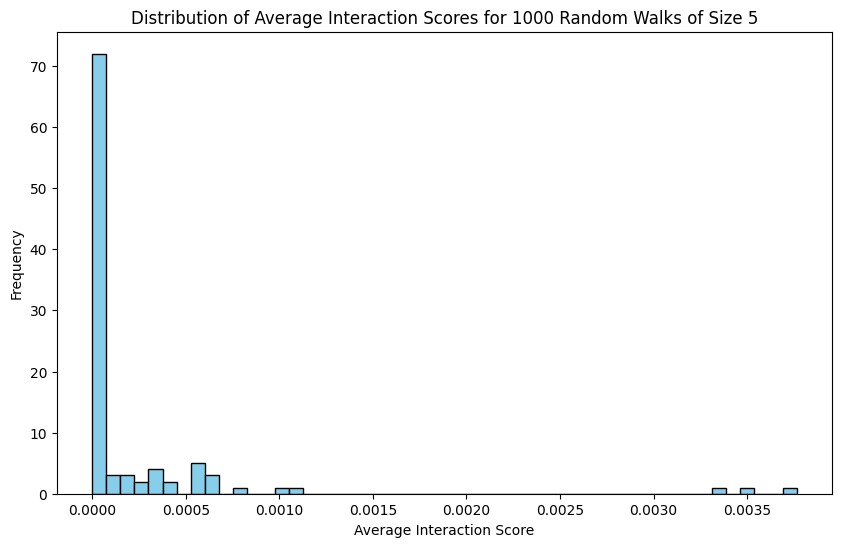

In [393]:
bg_model_random_walk_5 = f.create_background_model_rw(contact_matrix_zero, 5, num_molecules=1000, num_iterations=100, alpha=0.05)

In [402]:
f.simple_p_test(rw_score_5, bg_model_random_walk_5)

np.float64(0.16)

In [400]:
rw_score_5

np.float64(0.0003882285340160518)

## Random Walk Clique Size 5 with 100 molecules

Processing: 100%|██████████| 1000/1000 [04:50<00:00,  3.44iteration/s]


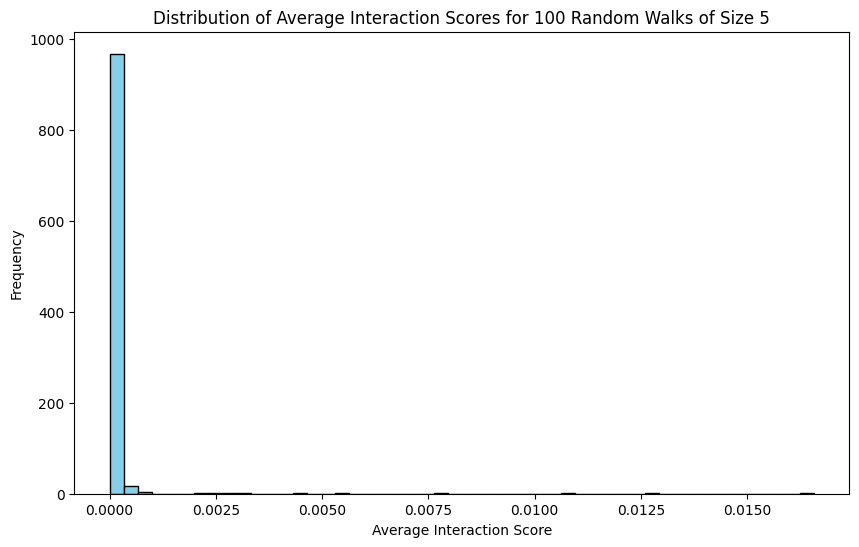

In [409]:
bg_model_random_walk_sample = f.create_background_model_rw(contact_matrix_zero, 5, num_molecules=100, num_iterations=1000, alpha=0.05)

In [418]:
top_nodes = f.random_walk(contact_matrix_zero, TTN_BIN, 5, num_molecules=100, alpha=0.05, verbose=True) 
rw_score_5  = f.calculate_avg_interaction_strength(contact_matrix_zero, top_nodes)
rw_score_5  


100%|██████████| 100/100 [00:00<00:00, 297.81it/s]


np.float64(0.0003770925531242224)

In [420]:
f.simple_p_test(rw_score_5, bg_model_random_walk_sample)

np.float64(0.031)

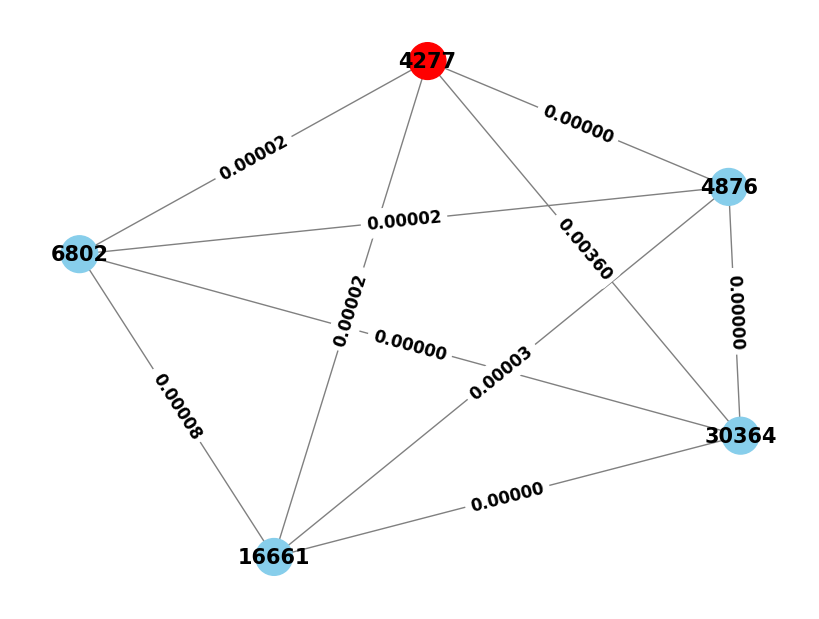

In [430]:
nodes = [ 4277, 30364, 16661,  6802,  4876]
f.clique_to_graph(contact_matrix_zero, nodes, TTN_BIN)   


## Random Walk Clique Size 10

In [ ]:
top_nodes = f.random_walk(contact_matrix_zero, TTN_BIN, 10, num_molecules=1000, alpha=0.05, verbose=True) 
rw_score_10  = f.calculate_avg_interaction_strength(contact_matrix_zero, top_nodes)

100%|██████████| 1000/1000 [00:03<00:00, 286.90it/s]


Processing: 100%|██████████| 100/100 [04:38<00:00,  2.79s/iteration]


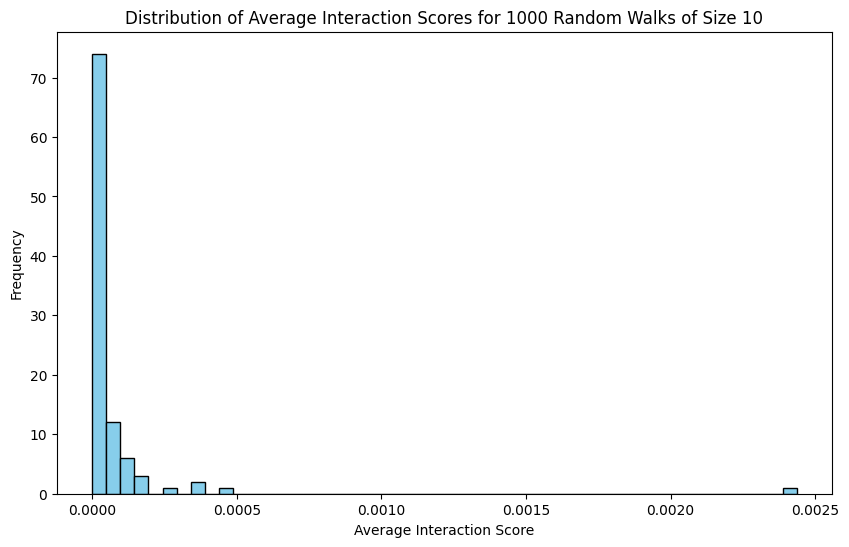

In [388]:
bg_model_random_walk_10 = f.create_background_model_rw(contact_matrix_zero, 10, num_molecules=1000, num_iterations=100, alpha=0.05)
# save list of scores in /background_models

with open('/Users/ethan/Desktop/chromatin-heart-dev/background_models/rw_scores_10.txt', 'w') as f:
    for item in bg_model_random_walk_10:
        f.write("%s\n" % item)

In [557]:
f.simple_p_test(rw_score_10, bg_model_random_walk_10)

np.float64(0.31)

In [392]:
rw_score_10

np.float64(4.0472059410651015e-05)

## RW Clique Size 15

Processing: 100%|██████████| 1000/1000 [50:01<00:00,  3.00s/iteration]


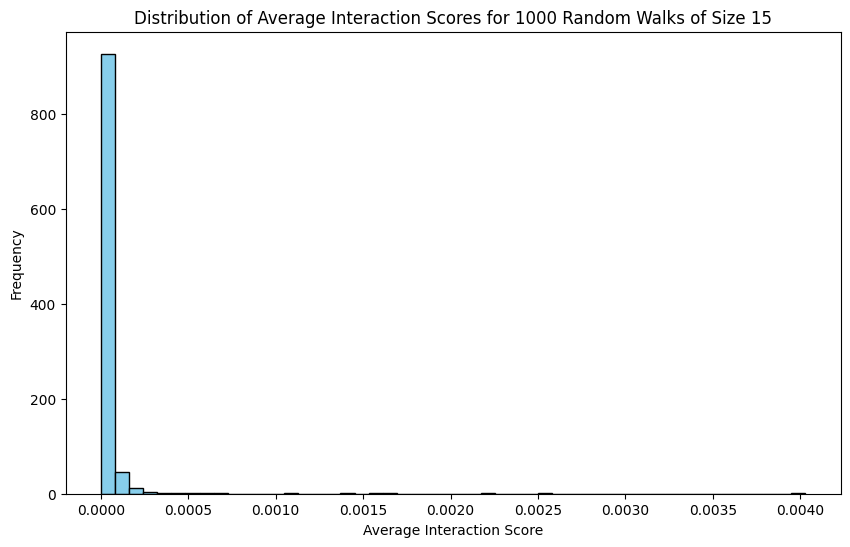

In [490]:
bg_model_random_walk_15 = f.create_background_model_rw(contact_matrix_zero, 15, num_molecules=1000, num_iterations=1000, alpha=0.05)

In [496]:
top_nodes_rw_15 = f.random_walk(contact_matrix_zero, TTN_BIN, 15, num_molecules=1000, alpha=0.05, verbose=True) 
rw_score_15  = f.calculate_avg_interaction_strength(contact_matrix_zero, top_nodes)
print(top_nodes_rw_15)
print(rw_score_15)

100%|██████████| 1000/1000 [00:03<00:00, 297.18it/s]

[ 4275 27734 24275 24937 20669 16879 11312 25597 27958 11448 17531 26857
 21873 28048 20209]
0.0003770925531242224


In [497]:
import functions as f
f.simple_p_test(rw_score_15, bg_model_random_walk_15)

np.float64(0.013)

## Testing RW Parameters

In [483]:
test_nodes = f.random_walk(contact_matrix_zero, TTN_BIN, 5, num_molecules=10000, alpha=0.05, verbose=True) 
f.calculate_avg_interaction_strength(contact_matrix_zero, test_nodes)


100%|██████████| 10000/10000 [00:29<00:00, 343.05it/s]


np.float64(4.16602102400624e-05)

In [487]:
test_nodes

array([ 4275, 14377,  1568, 24933, 28563])

## Plot of Clique Size to P Value

In [514]:
from scipy import stats

def t_test(observed_score, score_list):
    t_stat, p_value = stats.ttest_1samp(score_list, observed_score)
    return p_value


def mann_whitney_u_test(ttn_score, random_scores):
    ttn_array = np.array([ttn_score] * len(random_scores)) 
    u_statistic, p_value = stats.mannwhitneyu(ttn_array, random_scores, alternative='greater')
    return p_value





In [539]:
TTN_BIN

4275

Processing: 100%|██████████| 1000/1000 [02:27<00:00,  6.77iteration/s]


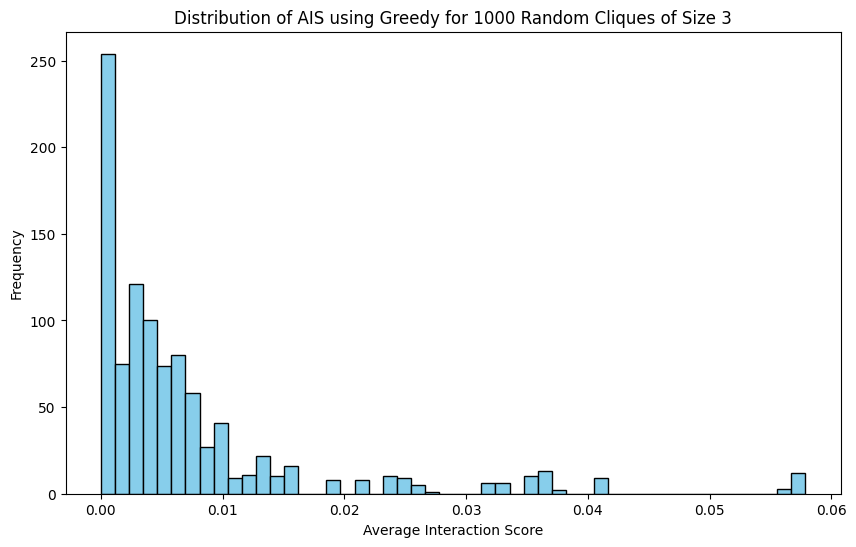

Processing: 100%|██████████| 1000/1000 [03:39<00:00,  4.56iteration/s]


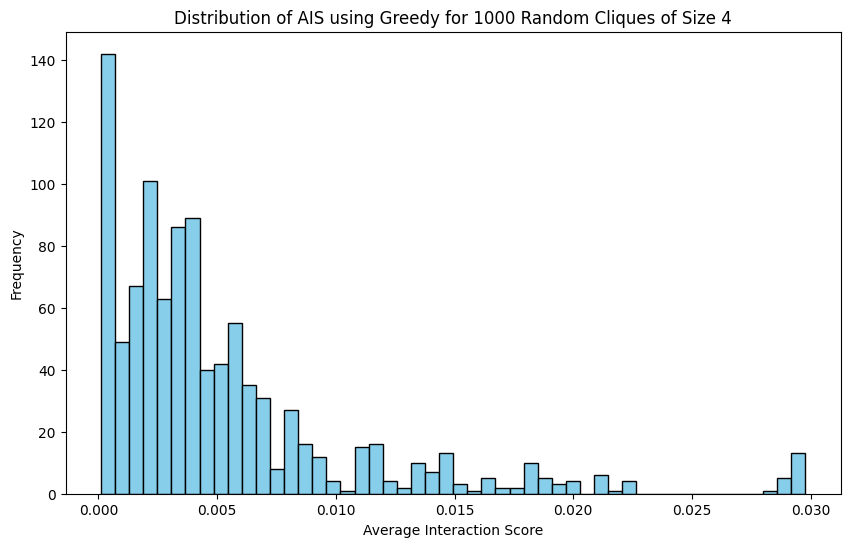

Processing: 100%|██████████| 1000/1000 [05:12<00:00,  3.20iteration/s]


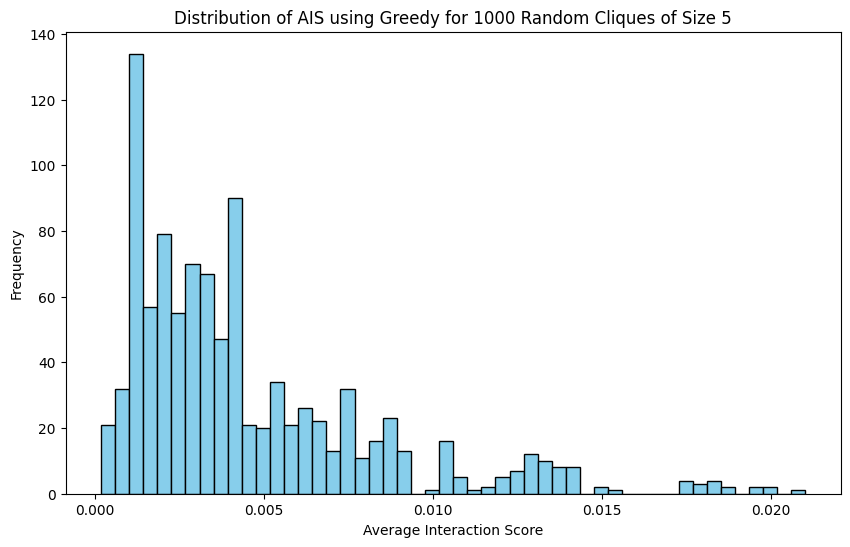

Processing: 100%|██████████| 1000/1000 [10:43<00:00,  1.55iteration/s]


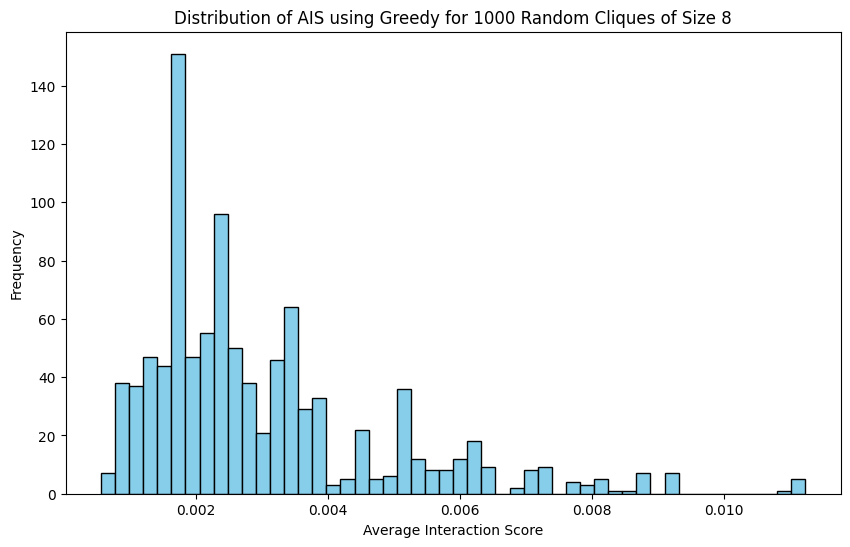

Processing: 100%|██████████| 1000/1000 [14:14<00:00,  1.17iteration/s]


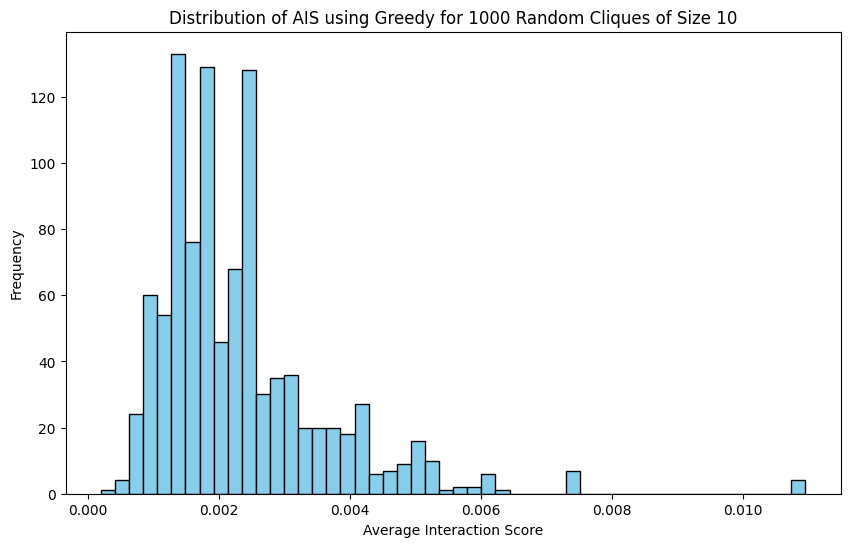

Processing: 100%|██████████| 1000/1000 [27:06<00:00,  1.63s/iteration]


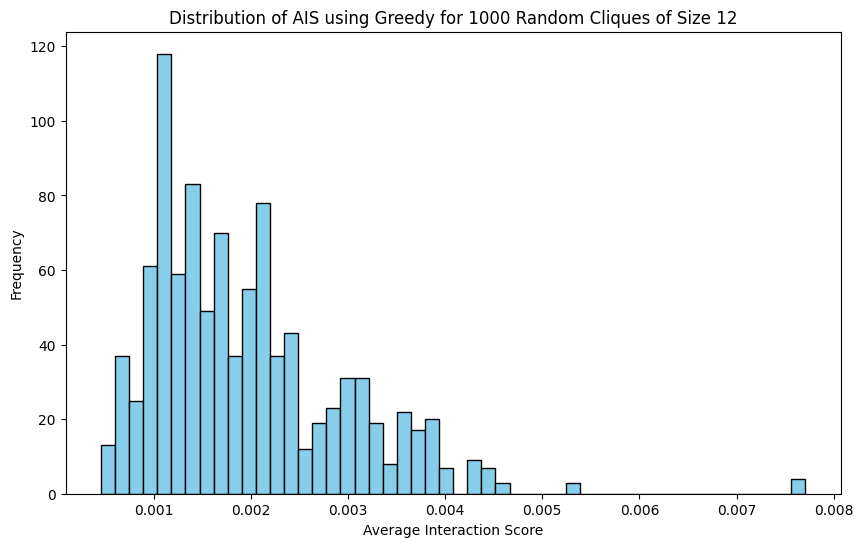

Processing: 100%|██████████| 1000/1000 [50:51<00:00,  3.05s/iteration] 


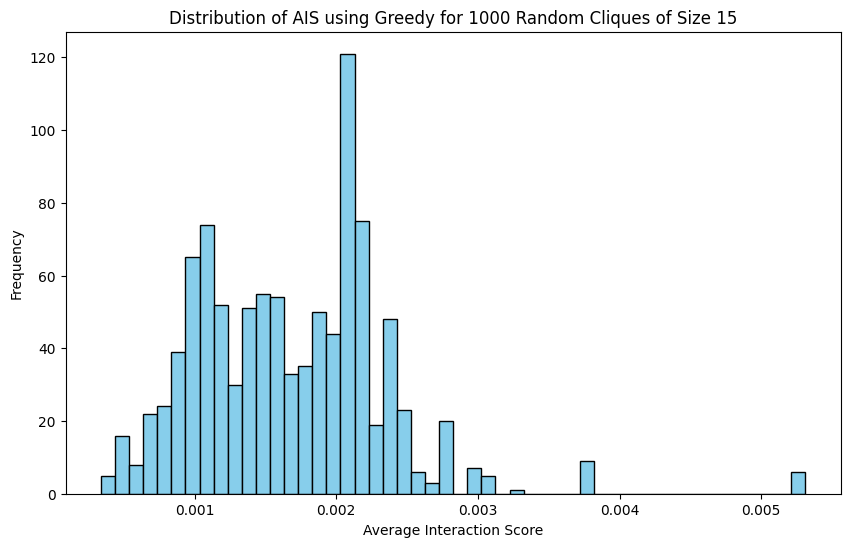

Processing: 100%|██████████| 1000/1000 [1:51:19<00:00,  6.68s/iteration] 


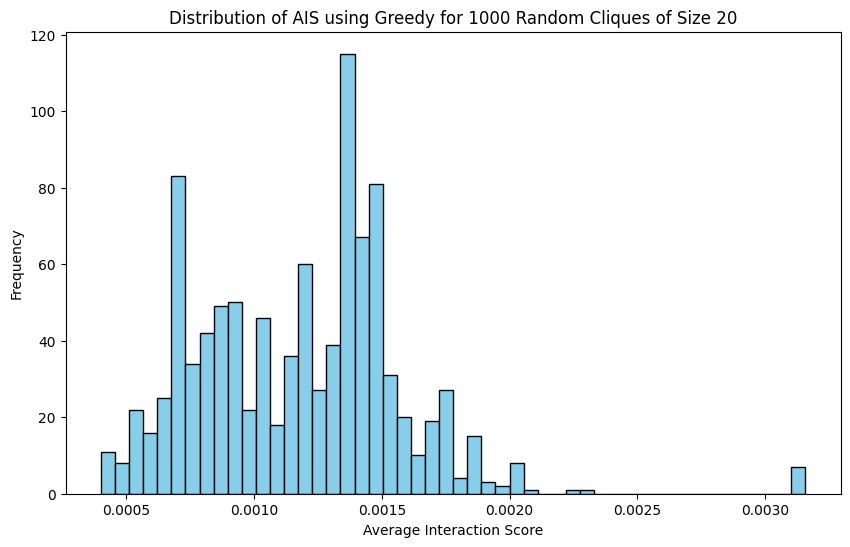

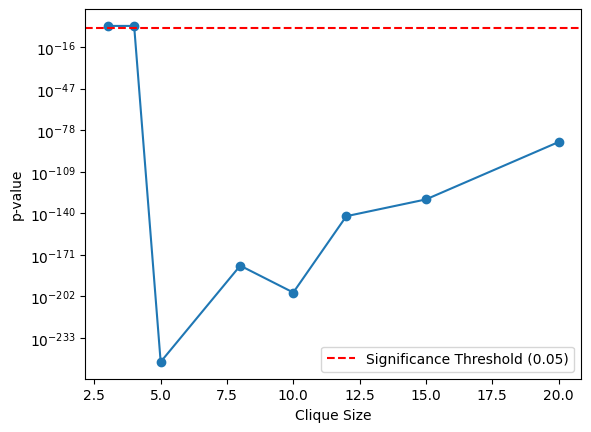

In [542]:
from tqdm import tqdm

clique_sizes = [3, 4, 5, 8, 10, 12, 15, 20]
p_values = []

for i in clique_sizes:
    top_nodes = f.find_clique_greedy(contact_matrix_zero, i, TTN_BIN, bin_map)
    greedy_score = f.calculate_avg_interaction_strength(contact_matrix_zero, top_nodes)
    bg_model_greedy = f.create_background_model_greedy(contact_matrix_zero, i, bin_map, num_iterations=1000)
    
    p_value = mann_whitney_u_test(greedy_score, bg_model_greedy) 
    p_values.append(p_value)

plt.plot(clique_sizes, p_values, marker='o')
plt.xlabel('Clique Size')
plt.ylabel('p-value')
plt.yscale('log')  # Useful if values vary widely
plt.axhline(0.05, color='r', linestyle='--', label='Significance Threshold (0.05)')
plt.legend()
plt.show()

In [550]:
clique_sizes

[3, 4, 5, 8, 10, 12, 15, 20]

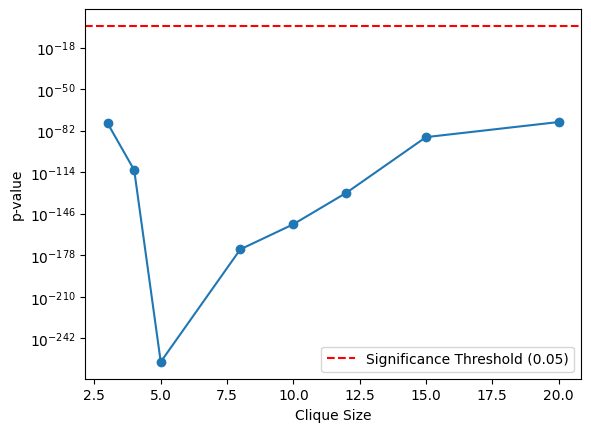

In [560]:
p_values = []

for i in clique_sizes:
    with open(f'/Users/ethan/Desktop/chromatin-heart-dev/background_models/greedy_scores_{i}_iterations_1000.txt', 'r') as bg:
        bg_scores = bg.read().splitlines()
        bg_scores = [float(score) for score in bg_scores]

        top_nodes = f.find_clique_greedy(contact_matrix_zero, i, TTN_BIN, bin_map)
        greedy_score = f.calculate_avg_interaction_strength(contact_matrix_zero, top_nodes)

        p_value = t_test(greedy_score, bg_scores)
        p_values.append(p_value)


plt.plot(clique_sizes, p_values, marker='o')
plt.xlabel('Clique Size')
plt.ylabel('p-value')
plt.yscale('log')  # Useful if values vary widely
plt.axhline(0.05, color='r', linestyle='--', label='Significance Threshold (0.05)')
plt.legend()
plt.show()

In [573]:
def get_stats_from_bg_model(type, clique_size, iterations):
    file_suffix = 'iterations' if type == 'greedy' else 'molecules'
    file_path = f'/Users/ethan/Desktop/chromatin-heart-dev/background_models/{type}_scores_{clique_size}_{file_suffix}_{iterations}.txt'
    
    with open(file_path, 'r') as bg:
        bg_scores = [float(score) for score in bg.read().splitlines()]
    
    top_nodes = f.find_clique_greedy(contact_matrix_zero, clique_size, TTN_BIN, bin_map)
    greedy_score = f.calculate_avg_interaction_strength(contact_matrix_zero, top_nodes)

    mean_bg = np.mean(bg_scores)
    var_bg = np.var(bg_scores)
    std_bg = np.std(bg_scores)

    p_value = mann_whitney_u_test(greedy_score, bg_scores)
    percent_higher = np.mean(np.array(bg_scores) > greedy_score) * 100

    print(f'TTN Clique Score: {greedy_score:.4f}')
    print(f'Background Scores Mean: {mean_bg:.4f}')
    print(f'Background Scores Variance: {var_bg:.4f}')
    print(f'Background Scores Std Dev: {std_bg:.4f}')
    print(f'Percentage of Background Scores Higher Than TTN: {percent_higher:.2f}%')
    print(f'p-value: {p_value:.3e}')

In [574]:
get_stats_from_bg_model('greedy', 5, 1000)

TTN Clique Score: 0.0102
Background Scores Mean: 0.0045
Background Scores Variance: 0.0000
Background Scores Std Dev: 0.0038
Percentage of Background Scores Higher Than TTN: 9.10%
p-value: 1.229e-251


In [575]:
get_stats_from_bg_model('greedy', 8, 1000)

TTN Clique Score: 0.0051
Background Scores Mean: 0.0030
Background Scores Variance: 0.0000
Background Scores Std Dev: 0.0019
Percentage of Background Scores Higher Than TTN: 15.50%
p-value: 9.693e-180


In [572]:
import numpy as np
from scipy.stats import norm

# Given values
ttn_score = 0.0051
mean_bg = 0.0030
std_bg = 0.0019

# Z-score calculation
z_score = (ttn_score - mean_bg) / std_bg

# P-value calculation from Z-score (one-tailed test)
p_value_from_z = 1 - norm.cdf(z_score)

print(f'Z-score: {z_score:.2f}')
print(f'P-value from Z-score: {p_value_from_z:.3e}')

Z-score: 1.11
P-value from Z-score: 1.345e-01


## Molecules vs Time

100%|██████████| 250000/250000 [14:27<00:00, 288.27it/s] 


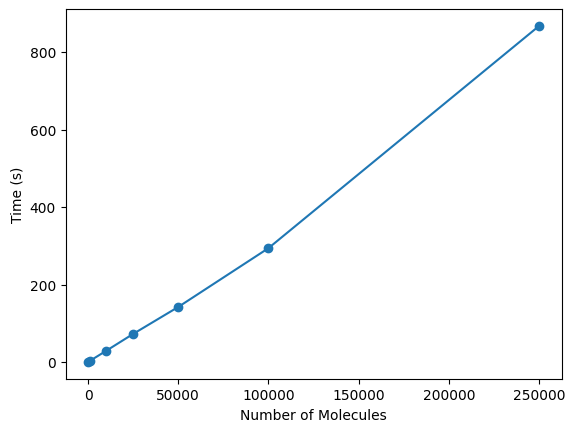

In [10]:
import time
# plot molecules to time
molecules = [100,1000,10000,25000,50000, 100000, 250000]
time_values = []

for m in molecules:
    start = time.time()
    top_nodes = f.random_walk(contact_matrix_zero, TTN_BIN, 5, num_molecules=m, alpha=0.05, verbose=True)
    end = time.time()
    time_values.append(end-start)

plt.plot(molecules, time_values, marker='o')
plt.xlabel('Number of Molecules')
plt.ylabel('Time (s)')
plt.show()


## Alpha vs Time

100%|██████████| 1000/1000 [00:00<00:00, 2950.89it/s]


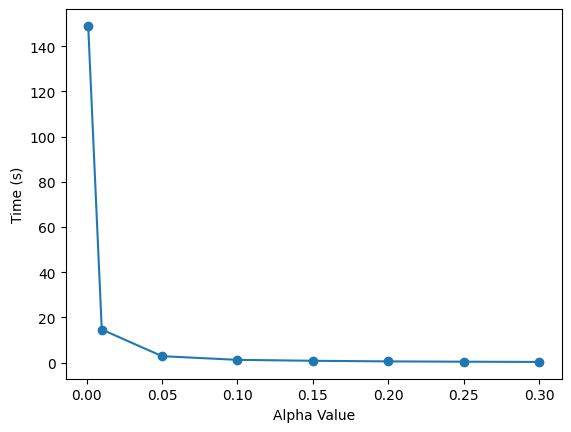

In [12]:
# plot alpha values to time using clique size 5
alphas = [0.001, 0.01, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3]
time_values = []

for a in alphas:
    start = time.time()
    top_nodes = f.random_walk(contact_matrix_zero, TTN_BIN, 5, num_molecules=1000, alpha=a, verbose=True)
    end = time.time()
    time_values.append(end-start)

plt.plot(alphas, time_values, marker='o')
plt.xlabel('Alpha Value')
plt.ylabel('Time (s)')
plt.show()



## Alpha vs p value, (for now can use clique size 5)

In [8]:
top_nodes

array([ 4277, 30386, 28366, 30438,  9294])

In [6]:
top_nodes

array([ 4277, 30364,  6840,  5342, 28072])

Processing: 100%|██████████| 1000/1000 [20:06<00:00,  1.21s/iteration]


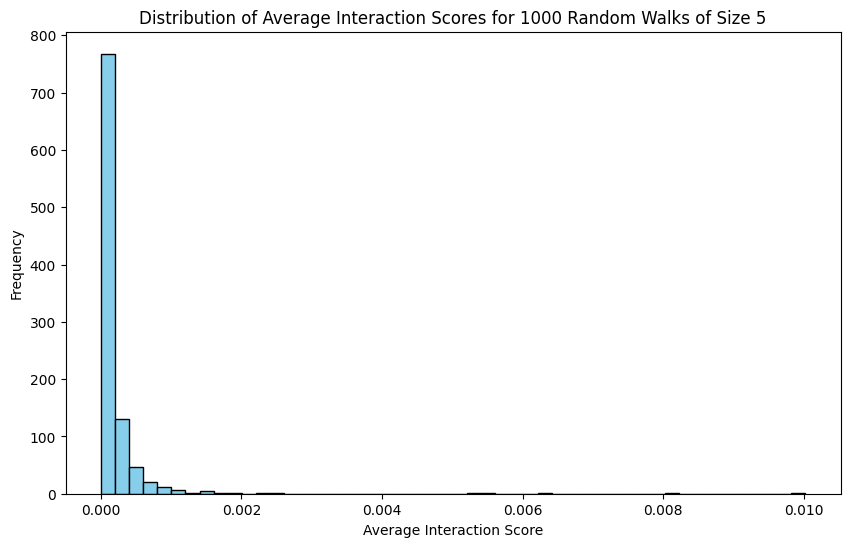

NameError: name 'mann_whitney_u_test' is not defined

In [16]:
from tqdm import tqdm
import matplotlib.pyplot as plt

alphas = [0.1, 0.2, 0.3, 0.5, 0.99]
p_values = []

for a in alphas:
    top_nodes = f.random_walk(contact_matrix_zero, TTN_BIN, 5, num_molecules=1000, alpha=a, verbose=True)
    rw_score = f.calculate_avg_interaction_strength(contact_matrix_zero, top_nodes)
    bg_model_rw = f.create_background_model_rw(contact_matrix_zero, 5, num_molecules=1000, num_iterations=1000, alpha=a)

    p_value = mann_whitney_u_test(rw_score, bg_model_rw)
    p_values.append(p_value)

plt.plot(alphas, p_values, marker='o')
plt.xlabel('Reset Probability (alpha)')
plt.ylabel('p-value')
plt.yscale('log')  # Log scale if values vary widely
plt.axhline(0.05, color='r', linestyle='--', label='Significance Threshold (0.05)')
plt.legend()
plt.show()

## Bed Narrow Peak